In [3]:
import sys
import os
from IPython.display import Markdown
from env_key_manager import APIKeyManager

# 创建实例
key_manager = APIKeyManager()

# 设置环境变量
key_manager.setup_api_key(["OPENAI_API_KEY", "OPENAI_BASE_URL", "LANGSMITH_ENDPOINT", "LANGSMITH_API_KEY", "LANGSMITH_PROJECT"])

os.environ['LANGSMITH_TRACING'] = "true"

# 查看Python版本
!python -V
# 查看安装的库
if 'win' in sys.platform.lower():
    !pip list | findstr "lang openai llm tiktoken chromadb cryptography duck unstructured numpy scipy"
else:
    !pip list | grep -E "lang|openai|llm|tiktoken|chromadb|cryptography|duck|unstructured|numpy|scipy"

Python 3.10.16
chromadb                                 0.6.3
cryptography                             44.0.2
duckduckgo_search                        6.3.7
langchain                                0.3.21
langchain-chroma                         0.2.2
langchain-community                      0.3.20
langchain-core                           0.3.49
langchain-deepseek                       0.1.3
langchain-openai                         0.3.11
langchain-text-splitters                 0.3.7
langgraph                                0.3.21
langgraph-checkpoint                     2.0.23
langgraph-prebuilt                       0.1.7
langgraph-sdk                            0.1.60
langserve                                0.3.1
langsmith                                0.3.8
numpy                                    1.26.4
openai                                   1.69.0
scipy                                    1.15.2
tiktoken                                 0.9.0


# 构建检索增强生成（RAG）应用：第一部分

大型语言模型（LLMs）最强大的应用之一是复杂的问答（Q&A）聊天机器人。这类应用能够回答关于特定源信息的问题。它们采用了一种称为检索增强生成（Retrieval Augmented Generation，简称[RAG](/docs/concepts/rag/)）的技术。

这是一个多部分教程：

- [第一部分](/docs/tutorials/rag)（本指南）介绍RAG并逐步演示一个最小化实现方案。
- [第二部分](/docs/tutorials/qa_chat_history) 扩展了实现功能，以支持对话式交互和多步骤检索流程。

本教程将展示如何构建一个简单的问答应用程序
在处理文本数据源的过程中，我们将逐步讲解一个典型的问答流程。
架构并重点介绍更多高级问答技术的额外资源。我们还将看到
LangSmith 如何帮助我们追踪和理解应用程序。
随着我们应用程序的不断发展，LangSmith将变得越来越有用
复杂性。

如果您已经熟悉基础检索，您可能还会对以下内容感兴趣：
这篇[不同检索技术的高级概述](/docs/concepts/retrieval)

**注意**：这里我们主要关注非结构化数据的问答。如果您对基于结构化数据的检索增强生成（RAG）感兴趣，请参阅我们关于[SQL数据问答](/docs/tutorials/sql_qa)的教程。

## 概述
一个典型的RAG应用包含两个主要组件：

**索引**：一个用于从数据源摄取数据并建立索引的流水线。*这一过程通常是离线进行的。*

**检索与生成**：实际的RAG链式流程，在运行时接收用户查询并从索引中检索相关数据，随后将其传递给模型。

注意：本教程的索引部分将主要遵循[语义搜索教程](/docs/tutorials/retrievers)的内容。

从原始数据到答案最常见的完整流程如下：

### 索引
1. **加载**：首先我们需要加载数据。这可以通过[文档加载器](/docs/concepts/document_loaders)来完成。
2. **分割**：[文本分割器](/docs/concepts/text_splitters)将大型`文档`拆分为更小的片段。这对数据索引和模型输入都非常有用，因为大片段更难检索，且无法适配模型的有限上下文窗口。
3. **存储**：我们需要一个地方来存储和索引分割后的内容，以便后续进行搜索。这通常通过[向量数据库](/docs/concepts/vectorstores)和[嵌入模型](/docs/concepts/embedding_models)来实现。

![索引示意图](../../static/img/rag_indexing.png)

### 检索与生成
4. **检索**：根据用户输入，使用[检索器](/docs/concepts/retrievers)从存储中获取相关的拆分内容。
5. **生成**：一个[聊天模型](/docs/concepts/chat_models) / [大语言模型](/docs/concepts/text_llms)通过包含问题及检索数据的提示词来生成答案

![检索示意图](../../static/img/rag_retrieval_generation.png)

索引完数据后，我们将使用 [LangGraph](https://langchain-ai.github.io/langgraph/) 作为编排框架来实现检索和生成步骤。

## 安装

### Jupyter Notebook

本教程及其他教程或许在 [Jupyter notebooks](https://jupyter.org/) 中运行最为便捷。在交互式环境中学习指南是深入理解它们的绝佳方式。安装方法请参阅 [此处](https://jupyter.org/install)。

### 安装

本教程需要以下langchain依赖项：

import Tabs from '@theme/Tabs';
import TabItem from '@theme/TabItem';
import CodeBlock from "@theme/CodeBlock";

<Tabs>
  <TabItem value="pip" label="Pip" default>
  

In [2]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


  </TabItem>
  <TabItem value="conda" label="Conda">
<CodeBlock language="bash">conda install langchain-text-splitters langchain-community langgraph -c conda-forge</CodeBlock>
  </TabItem>
</Tabs>


更多详情，请参阅我们的[安装指南](/docs/how_to/installation)。

### LangSmith

使用LangChain构建的许多应用程序将包含多个步骤，涉及多次LLM调用。
随着这些应用变得越来越复杂，能够检查链或代理内部的具体运行情况变得至关重要。
最佳实践是使用 [LangSmith](https://smith.langchain.com)。

在以上链接完成注册后，请确保设置环境变量以开始记录追踪数据：

```shell
export LANGSMITH_TRACING="true"
export LANGSMITH_API_KEY="..."
```

```python
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
```

## 组件

我们需要从LangChain的集成套件中选择三个组件。

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [4]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [5]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [6]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore # InMemoryVectorStore: 用于存储向量的内存存储器

vector_store = InMemoryVectorStore(embeddings)

## 预览

在本指南中，我们将构建一个能够回答有关网站内容问题的应用程序。我们将使用的具体网站是[LLM驱动的自主
[智能体](https://lilianweng.github.io/posts/2023-06-23-agent/) 博客文章
作者 Lilian Weng 的研究成果使我们能够针对内容提出问题
帖子。

我们可以创建一个简单的索引管道和RAG链来实现这一点，代码量约50行
代码行数。

```python
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# 加载并分块处理博客内容
loader = WebBaseLoader(
web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
bs_kwargs=字典(
parse_only=bs4.SoupStrainer(
class_=("文章内容", "文章标题", "文章头部")
)
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# 索引块
_ = vector_store.add_documents(documents=all_splits)

# 定义问答提示
prompt = hub.pull("rlm/rag-prompt")


# 定义应用程序状态
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# 定义应用步骤
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# 编译应用程序和测试
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

response = graph.invoke({"question": "什么是任务分解？"})
print(response["answer"])
```

查看 [LangSmith 文档](https://docs.smith.langchain.com/) 了解更多信息。
[追踪](https://smith.langchain.com/public/65030797-7efa-4356-a7bd-b54b3dc70e17/r)

## 详细步骤说明

让我们逐步解析上述代码，以真正理解其
正在进行中。

## 1. 索引 {#indexing}

:::note

本节是[语义搜索教程](/docs/tutorials/retrievers)中内容的精简版本。
如果您熟悉[文档加载器](/docs/concepts/document_loaders)、[嵌入模型](/docs/concepts/embedding_models)和[向量数据库](/docs/concepts/vectorstores)的使用，
请随时跳转到下一节：[检索与生成](/docs/tutorials/rag/#orchestration)。

:::

### 加载文档

我们需要先加载博客文章内容。可以使用
[文档加载器](/docs/concepts/document_loaders)
为此，这些对象从数据源加载数据并返回一个
列表
[文档](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html)
对象。

在这种情况下，我们将使用
[WebBaseLoader](/docs/integrations/document_loaders/web_base),
它使用 `urllib` 从网页 URL 加载 HTML，并使用 `BeautifulSoup` 来
解析为文本。我们可以通过传递参数来自定义 HTML 到文本的解析方式
通过 `bs_kwargs` 将参数传入 `BeautifulSoup` 解析器（参见
[BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/)
文档](https://beautiful-soup-4.readthedocs.io/en/latest/#beautifulsoup)。
在这种情况下，仅包含类名为“post-content”、“post-title”或
“post-header”是相关的，因此我们将移除所有其他内容。

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# 只保留全HTML中的文章标题、头部和内容。
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"总字符数: {len(docs[0].page_content)}")

总字符数: 43130


In [9]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


#### 深入探索

`DocumentLoader`：一种对象，用于从数据源加载内容并将其转换为`Documents`列表。

- [文档](/docs/how_to#document-loaders):
关于如何使用 `DocumentLoaders` 的详细文档
- [集成](/docs/integrations/document_loaders/)：160+
可供选择的集成方案。
- [接口](https://python.langchain.com/api_reference/core/document_loaders/langchain_core.document_loaders.base.BaseLoader.html):
基础接口的API参考。

### 文档分割

我们的加载文档已超过42,000个字符，内容过长无法完整显示
许多模型的上下文窗口内。即便是对于那些能够
在上下文中完整适配整篇帖子时，模型可能难以准确捕捉
超长输入中的信息。

为了解决这个问题，我们将把 `Document` 分割成多个块进行嵌入处理，
向量存储。这应有助于我们仅检索最相关的部分
在博客文章运行时。

与[语义搜索教程](/docs/tutorials/retrievers)中一样，我们使用了
[递归字符文本分割器](/docs/how_to/recursive_text_splitter)
这将递归地使用常见分隔符来分割文档
在确保每个数据块大小合适之前持续添加新行。这是
适用于通用文本场景的推荐文本分割器。

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # 块大小（字符）
    chunk_overlap=200,  # 块重叠（字符）
    add_start_index=True,  # 在原始文档中跟踪索引
)
all_splits = text_splitter.split_documents(docs)

print(f"将博客文章拆分为{len(all_splits)}个子文档。")

将博客文章拆分为66个子文档。


#### 深入探索

`TextSplitter`：用于将`Document`列表拆分为更小部分的对象
块。`DocumentTransformer` 的子类。

- 通过阅读[操作指南文档](/docs/how_to#text-splitters)，了解更多关于使用不同方法拆分文本的信息
- [代码（Python 或 JavaScript）](/docs/integrations/document_loaders/source_code)
- [科学论文](/docs/integrations/document_loaders/grobid)
- [接口](https://python.langchain.com/api_reference/text_splitters/base/langchain_text_splitters.base.TextSplitter.html): 基础接口的API参考文档。

`DocumentTransformer`：对列表执行转换操作的对象
由 `Document` 对象组成的集合。

- [文档](/docs/how_to#text-splitters): 关于如何使用 `DocumentTransformers` 的详细文档
- [集成](/docs/integrations/document_transformers/)
- [接口](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.transformers.BaseDocumentTransformer.html): 基础接口的API参考文档。

### 存储文档

现在我们需要为66个文本块建立索引，以便能够对它们进行搜索
在运行时。按照[语义搜索教程](/docs/tutorials/retrievers)进行操作，
我们的方法是将每个文档分割的内容[嵌入](/docs/concepts/embedding_models/)，并插入这些嵌入向量
存入[向量存储](/docs/concepts/vectorstores/)。给定输入查询后，我们便可利用
向量搜索以检索相关文档。

我们可以通过一条命令嵌入并存储所有文档分割内容
使用在[教程开始](/docs/tutorials/rag/#components)时选择的向量存储和嵌入模型。

In [11]:
# 将所有拆分的文档添加到向量存储器中
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['4941b579-5bfb-4575-a95d-f9d6f12508dd', 'ce3b4b58-c034-4f91-a96c-6a07eef26b0a', 'dbd8b9a2-ebd9-4726-9ed6-59873c40c3d5']


#### 深入探索

`Embeddings`: 围绕文本嵌入模型的封装器，用于转换
文本到嵌入向量。

- [文档](/docs/how_to/embed_text): 关于如何使用嵌入的详细文档。
- [集成](/docs/integrations/text_embedding/)：提供30多种集成方案供选择。
- [接口](https://python.langchain.com/api_reference/core/embeddings/langchain_core.embeddings.Embeddings.html): 基础接口的API参考文档。

`VectorStore`：向量数据库的封装器，用于存储和
查询嵌入向量。

- [文档](/docs/how_to/vectorstores): 关于如何使用向量存储的详细文档。
- [集成](/docs/integrations/vectorstores/)：提供40多种集成方案供选择。
- [接口](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.base.VectorStore.html): 基础接口的API参考文档。

至此，流水线的**索引构建**部分已完成。此时
我们拥有一个可查询的向量存储库，其中包含经过分块处理的内容
博客文章。针对用户提出的问题，我们理想情况下应当能够返回
博客文章中回答该问题的片段。

## 2. 检索与生成 {#orchestration}

现在让我们来编写实际的应用程序逻辑。我们想要创建一个简单的
一款接收用户问题、搜索相关文档的应用程序
对于该问题，将检索到的文档和初始问题传递给
一个模型，并返回一个答案。

在生成阶段，我们将使用[教程开头](/docs/tutorials/rag/#components)选定的聊天模型。

我们将使用一个已提交至LangChain提示中心的RAG提示模板
([此处](https://smith.langchain.com/hub/rlm/rag-prompt))。

In [12]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "（上下文在这里）", "question": "（问题在这里）"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: （问题在这里） 
Context: （上下文在这里） 
Answer:


我们将使用 [LangGraph](https://langchain-ai.github.io/langgraph/) 将检索和生成步骤整合到一个应用程序中。这将带来诸多优势：

- 我们可以一次性定义应用逻辑，并自动支持多种调用模式，包括流式调用、异步调用和批量调用。
- 我们通过 [LangGraph 平台](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/) 实现了简化的部署流程。
- LangSmith 会自动追踪我们应用程序的各个步骤。
- 我们可以轻松地为应用程序添加关键功能，包括[持久化](https://langchain-ai.github.io/langgraph/concepts/persistence/)和[人工介入审批](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/)，只需进行最少的代码改动。

要使用LangGraph，我们需要定义以下三件事：

1. 我们应用程序的状态；
2. 我们应用程序的节点（即应用步骤）；
3. 应用程序的“控制流”（例如各步骤的执行顺序）。

#### 状态:

我们应用程序的[状态](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)控制着哪些数据被输入到应用程序、在步骤之间传递以及由应用程序输出。它通常是一个`TypedDict`，但也可以是一个[Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/)。

对于一个简单的RAG应用，我们只需记录输入问题、检索到的上下文和生成的答案：

In [13]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

#### 节点（应用步骤）

让我们从一个简单的两步序列开始：检索与生成。

In [14]:
def retrieve(state: State):
    """检索相关文档"""
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    """生成答案"""
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

我们的检索步骤仅使用输入问题进行相似性搜索，而生成步骤则将检索到的上下文和原始问题格式化为聊天模型的提示。

#### 控制流程

最后，我们将应用程序编译为一个单一的 `graph` 对象。在本例中，我们只是将检索和生成步骤连接成一个单一的序列。

In [15]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve") # 添加边
graph = graph_builder.compile()

LangGraph 还内置了可视化应用程序控制流程的实用工具：

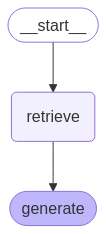

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

<details>
<summary>我需要使用LangGraph吗？</summary>

构建RAG应用并不一定需要LangGraph。实际上，我们可以通过单独调用各个组件来实现相同的应用逻辑。

```python
question = "..."

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": docs_content})
answer = llm.invoke(prompt)
```
LangGraph 的优势包括：

- 支持多种调用模式：若需实现输出令牌流式传输或分步结果流式传输，当前逻辑需重新编写；
- 通过 [LangSmith](https://docs.smith.langchain.com/) 自动支持追踪功能，并通过 [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/) 实现部署；
- 支持持久化、人在回路（human-in-the-loop）及其他特性。

许多应用场景需要在对话体验中实现检索增强生成（RAG），以便用户通过有状态的对话获取基于上下文的回答。正如我们将在教程[第二部分](/docs/tutorials/qa_chat_history)中看到的，LangGraph对状态的管理和持久化功能极大地简化了这类应用的开发。

</details>

#### 使用方法

让我们来测试我们的应用程序！LangGraph 支持多种调用模式，包括同步、异步和流式处理。

调用：

In [17]:
result = graph.invoke({"question": "什么是任务分解？"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='dbd8b9a2-ebd9-4726-9ed6-59873c40c3d5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='e23b43d5-acc2-4eaf-94d5-7516c7961cfa', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT b

流程步骤：

In [18]:
for step in graph.stream(
    {"question": "什么是任务分解？"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='dbd8b9a2-ebd9-4726-9ed6-59873c40c3d5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='e23b43d5-acc2-4eaf-94d5-7516c7961cfa', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 202

流式传输 [令牌](/docs/concepts/tokens/)：

In [17]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| more| manageable| steps|.| It| can| be| achieved| through| techniques| like| Chain| of| Thought| (|Co|T|)| prompting|,| which| encourages| the| model| to| think| step| by| step|,| or| through| more| structured| methods| like| the| Tree| of| Thoughts|.| This| approach| not| only| simplifies| task| execution| but| also| provides| insights| into| the| model|'s| reasoning| process|.||

:::提示

对于异步调用，请使用：

```python
result = await graph.ainvoke(...)
async for step in graph.astream(...):
```

#### 返回来源

请注意，通过将检索到的上下文存储在图表的状态中，我们可以在状态的 `"context"` 字段中获取模型生成答案的来源。有关返回来源的更多详细信息，请参阅[本指南](/docs/how_to/qa_sources/)。

#### 深入探索

[聊天模型](/docs/concepts/chat_models)接收一系列消息并返回一条消息。

- [文档](/docs/how_to#chat-models)
- [集成](/docs/integrations/chat/)：提供25种以上集成方案供选择。
- [接口](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html): 基础接口的API参考文档。

**自定义提示词**

如上所示，我们可以加载提示（例如，[这个RAG
[提示](https://smith.langchain.com/hub/rlm/rag-prompt) 来自提示
中心。提示词也可以轻松定制。例如：

In [19]:
from langchain_core.prompts import PromptTemplate

template = """使用以下上下文来回答最终的问题。
如果你不知道答案，就说你不知道，不要尝试编造答案。
最多使用三句话，并尽量使答案简洁。
总是以"谢谢你问！"结尾。

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## 查询分析

截至目前，我们一直使用原始输入查询执行检索。然而，允许模型为检索目的生成查询具有一些优势，例如：

- 除了语义搜索，我们还可以构建结构化过滤器（例如，“查找2020年以来的文档”）。
- 该模型能够将用户可能包含多方面内容或无关语言的查询，重写为更有效的搜索查询。

[查询分析](/docs/concepts/retrieval/#query-analysis)通过模型将原始用户输入转换或构建为优化的搜索查询。我们可以轻松地在应用程序中加入查询分析步骤。出于演示目的，让我们为向量存储中的文档添加一些元数据。我们将为文档添加一些（人为设计的）可筛选段落。

In [19]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

我们需要更新向量存储中的文档。为此，我们将使用简单的 [InMemoryVectorStore](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html)，因为它具备我们所需的特定功能（例如元数据过滤）。请参考向量存储的 [集成文档](/docs/integrations/vectorstores/) 以了解所选向量存储的相关功能。

In [20]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

接下来，让我们为搜索查询定义一个模式。为此，我们将使用[结构化输出](/docs/concepts/structured_outputs/)。这里我们将查询定义为一个包含字符串查询和文档部分（可以是"开头"、"中间"或"结尾"）的对象，但您可以根据需要自由定义。

In [21]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

最后，我们在LangGraph应用中增加一个步骤，用于根据用户的原始输入生成查询：

In [22]:
class State(TypedDict):
    question: str
    # highlight-next-line
    query: Search
    context: List[Document]
    answer: str


# highlight-next-line
def analyze_query(state: State):
    # highlight-next-line
    structured_llm = llm.with_structured_output(Search)
    # highlight-next-line
    query = structured_llm.invoke(state["question"])
    # highlight-next-line
    return {"query": query}


def retrieve(state: State):
    # highlight-start
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    # highlight-end
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# highlight-start
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
# highlight-end
graph = graph_builder.compile()

<details>
<summary>完整代码：</summary>

```python
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
```markdown
from langchain_text_splitters import RecursiveCharacterTextSplitter
```
from langgraph.graph import START, StateGraph
```markdown
from typing_extensions import Annotated, List, TypedDict
```

# 加载并分块处理博客内容
```markdown
loader = WebBaseLoader(
```
web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
```markdown
bs_kwargs=dict(
```
```markdown
parse_only=bs4.SoupStrainer(
```
class_=("文章内容", "文章标题", "文章头部")
)
)
好的,我会按照要求将英文翻译成中文,并保持标准的markdown格式。以下是一个示例翻译:

# 欢迎使用翻译助手

这是一个**markdown格式**的翻译示例:

## 主要功能
- 提供准确的翻译服务
- 保持原始文档格式
- 支持多种语言互译

### 使用说明
1. 输入需要翻译的文本
2. 指定目标语言
3. 获取翻译结果

> 注意:翻译质量取决于原文的清晰度和专业性

如需更多帮助,请访问我们的[官方网站](https://example.com)
文档 = 加载器.加载()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# 更新元数据（用于说明用途）
total_documents = len(all_splits)
三分之一 = 总文档数 // 3

for i, document in enumerate(all_splits):
如果 i < 第三位：
document.metadata["section"] = "beginning"
    elif i < 2 * third:
document.metadata["section"] = "middle"
否则：
document.metadata["section"] = "end"


# 索引块
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# 定义搜索模式
```markdown
class Search(TypedDict):
```
"""搜索查询。"""

    query: Annotated[str, ..., "要运行的搜索查询。"]
    section: 标注部分
`["开头", "中间", "结尾"]`
...，
"待查询的章节。"
    ]

# 定义问答提示
prompt = hub.pull("rlm/rag-prompt")


# 定义应用程序状态
```markdown
class State(TypedDict):
```
问题: str
查询：搜索
上下文：文档列表
    answer: str


```markdown
def analyze_query(state: State):
```
structured_llm = llm.with_structured_output(搜索)
query = structured_llm.invoke(state["question"])
返回 {"query": query}


```markdown
def retrieve(state: State):
```
```markdown
query = state["query"]
```
检索到的文档 = 向量存储.相似性搜索(
        query["query"],
```markdown
filter=lambda doc: doc.metadata.get("section") == query["section"],
```
)
返回 {"context": retrieved_docs}


def generate(state: State):
docs_content = "\n\n".join(doc.page_content for doc in state["context"])
messages = prompt.invoke({"question": state["question"], "context": docs_content})
response = llm.invoke(messages)
返回 {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
好的,我会严格按照您的要求进行翻译,确保markdown格式一致。以下是一个示例翻译:

# Project Documentation

## Introduction
This document provides an overview of the XYZ project.

### Key Features
- Feature 1: Real-time data processing
- Feature 2: Cloud-based storage
- Feature 3: Cross-platform compatibility

## Installation
To install the software:
1. Download the package from [our website](https://example.com)
2. Run `install.sh` in terminal
3. Follow the on-screen instructions

> Note: Administrator privileges may be required during installation.

```python
def hello_world():
    print("Hello, World!")
```

| Parameter | Description |
|-----------|-------------|
| timeout   | Connection timeout in seconds |
| retries   | Number of connection retry attempts |

</details>

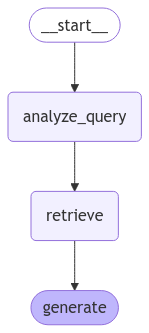

In [25]:
display(Image(graph.get_graph().draw_mermaid_png()))

我们可以通过明确要求获取帖子末尾的上下文来测试我们的实现。请注意，模型在其回答中包含了不同的信息。

In [25]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='d6cef137-e1e8-4ddc-91dc-b62bd33c6020', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39221, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj

无论是在流式处理的步骤中，还是在[LangSmith追踪记录](https://smith.langchain.com/public/bdbaae61-130c-4338-8b59-9315dfee22a0/r)里，我们现在都能观察到输入到检索步骤的结构化查询。

查询分析是一个涉及多种方法的复杂问题。更多示例请参考[操作指南](/docs/how_to/#query-analysis)。

## 后续步骤

我们已经介绍了基于数据构建基础问答应用的步骤：

- 使用[文档加载器](/docs/concepts/document_loaders)加载数据
- 使用[文本分割器](/docs/concepts/text_splitters)对索引数据进行分块处理，使其更易于模型使用
- [嵌入数据](/docs/concepts/embedding_models) 并将数据存储在[向量数据库](/docs/how_to/vectorstores)中
- [检索](/docs/concepts/retrievers) 先前存储的文本块以响应传入的问题
- 使用检索到的文本块作为上下文生成答案。

在[教程第2部分](/docs/tutorials/qa_chat_history)中，我们将扩展当前实现以支持对话式交互和多步骤检索流程。

进一步阅读：

- [返回来源](/docs/how_to/qa_sources): 了解如何返回源文档
- [流式传输](/docs/how_to/streaming): 了解如何流式输出结果及中间步骤
- [添加聊天记录](/docs/how_to/message_history): 了解如何为您的应用添加聊天记录功能
- [检索概念指南](/docs/concepts/retrieval): 关于特定检索技术的高层次概述